# Introduction

In this report I will examine a series of neural network models in order to perform 10-way classification using images. The dataset has been sourced form Kaggle [1] and is comprised of a small number of images for training and evaluation. This dataset is designed to test the finer points of computer vision classification due to most images being very similar and requires the implementation of transfer-learning, which will be explored in this report. 

Computer vision classification, or image labelling, requires convolutional neural networks which takes an image as an input and extracts abstract features which can be used in image classification [2]. In this report more advance forms of computer vision will be examined such depth-wise convolutions, whereby only one convolutional filter is applied per input channel [3]. I will also employ the use of batch normalisation which is a method that can adaptively normalize data even as the mean and variance change over time during the training process. This method is useful in creating deep neural networks as it assists with gradient propagation. Last but not least I will examine a pre-trained convnet like Xception, which can drastically improve the accuracy of a model compared to one trained from scratch. The final step will then be to fine tune the base Xception model to improve accuracy as much as possible.


#### Objectives
1. Develop a common-sense baseline.
2. Develop a small CNN model to beat the baseline.
3. Test a series of models for hyperparameter selection.
4. Evaluate best performing model.
5. Use a pre-trained convnet model and compare results with previously trained model.
6. Fine tune model and compare results.

#### Aim
1. Develop a high bias, low variance model.


### Problem Definition

###### What will the input data be?
A small dataset featuring 10 separate monkey species.

###### What will the model predict?
The monkey label given the input image.

###### What is the problem domain?
This is a multi-class classification task.

###### What is the measure of success?
Given that the number of input images is quite even, accuracy will be the measure of success.

### Module Library

Importing necessary libraries.

In [1]:
# Directory navigation libraries
import os, shutil, os.path
from pathlib import Path

# Image classifiaction pre-requisites
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import optimizers
from keras import layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils.layer_utils import count_params

# Pre-trained CNN libraries
from keras.applications.xception import Xception
from tensorflow import keras

# Baseline model
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Sk Learn confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# General use libraries
import numpy as np
import pandas as pd
import re
from keras.models import load_model
import itertools

# Graph enabling library
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

# Library for splitting directories into train, test, validate
import splitfolders

## Dataset Pre-processing

The raw download contains just two folders one for testing and one for training. In order to assess, improve and optimise hyperparameters we also require a third dataset on which to validate the accuracy of the model.

The 'splitfolders' library provides exactly this functionality which greatly simplifies the task of folder navigation and splitting based upon the required percentages.

In [2]:
# Split the training folder into training and validation using an 80/20 split.

# splitfolders.ratio('C:\\Users\\Stas\\Desktop\\monkey_images\\training\\training', 
#                    output='C:\\Users\\Stas\Desktop\\monkey_images\\train_validation_split', seed=111, 
#                    ratio=(0.8, 0.2))

Directory paths must be set for the three folders which will be called upon during generator creation.

In [3]:
train_set = Path('C:\\Users\\Stas\\Desktop\\monkey_images\\train_validation_split\\train')
validation_set = Path('C:\\Users\\Stas\\Desktop\\monkey_images\\train_validation_split\\val')
test_set = Path('C:\\Users\\Stas\Desktop\\monkey_images\\testing\\testing') 

### Image Generators

The images need to be processed into floating point tensors before model training can begin. One way to accomplish this is through the use of generators, which continuously process images from a specified folder into batches of preprocessed tensors. The image generators below will be directed towards the three folders previously created for testing, training and validation. 

A few points to note:
1. The height and width are set to 150 pixels. This will resize all images in the directory to this specification.
2. Class mode is set to categorical, which is useful for mutually exclusive labels. This is a 2D output of one-hot encoded labels.
3. Interpolation method set to nearest. This method is used to resample the images to the target size of 150 pixels.

In [4]:
# Defining parameters.
height = 150
width = 150
channels = 3
batch_size = 32

In [5]:
# Creating training generator.
train_generator = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(
                            train_set,
                            target_size = (height, width),
                            batch_size = batch_size,
                            class_mode = 'categorical',
                            color_mode = 'rgb',
                            interpolation = 'nearest',
                            classes = None)

Found 874 images belonging to 10 classes.


In [6]:
# Creating validation generator.
validation_generator = image.ImageDataGenerator(rescale=1./255).flow_from_directory(
                            validation_set,
                            target_size = (height, width),
                            batch_size = batch_size,
                            class_mode = 'categorical',
                            color_mode = 'rgb',
                            interpolation = 'nearest',
                            classes = None)

Found 224 images belonging to 10 classes.


In [7]:
# Creating test generator.
test_generator = image.ImageDataGenerator(rescale=1./255).flow_from_directory(
                            test_set,
                            target_size = (height, width),
                            class_mode = 'categorical',
                            color_mode = 'rgb',
                            interpolation = 'nearest',
                            classes = None,
                            shuffle=False)

Found 272 images belonging to 10 classes.


### Examining the Dataset

It is important to understand the dataset and its limitations to better adjust the model training workflow.

The dataset also comes with a text file outlining some basic information about the dataset such as the number of training images, number of validation images and the label per class.

This will be loaded using a pandas dataframe where it can be further inspected.

In [8]:
# Loading labels text file into pandas dataframe.
labels_df = pd.read_csv('C:\\Users\\Stas\\Desktop\\monkey_images\\monkey_labels.txt')

In [9]:
# Examining the dataframe.
labels_df

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [10]:
# Removing excess whitespace from column names.
labels_df.columns = labels_df.columns.str.replace(' ', '')

In [11]:
print(f"Total number of Training Images: {labels_df['TrainImages'].sum()}")
print(f"Total number of Testing Images: {labels_df['ValidationImages'].sum()}")

Total number of Training Images: 1370
Total number of Testing Images: 272


Based upon the text file read there are a total of 1370 images for training purposes and 272 images for testing purposes. 

This number will be verified using the code below which will walk through he given directory and iteratively increase the count ticker for each file found. Comments will be provided for the first cell block only as subsequent blocks are identical.

In [12]:
# Keep count of images in folder.
train_count = 0

# Iterate through the training directory.
for root, directories, filenames in os.walk(train_set):
    
    # Increase count by one for each image in directory.
    for files in filenames:
        train_count+=1
        
print(f'Number of training images - {train_count}')

Number of training images - 874


In [13]:
valid_count = 0
for root, directories, filenames in os.walk(validation_set):
    for files in filenames:
        valid_count+=1
        
print(f'Number of validation images - {valid_count}')

Number of validation images - 224


In [14]:
test_count = 0
for root, directories, filenames in os.walk(test_set):
    for files in filenames:
        test_count+=1
        
print(f'Number of testing images - {test_count}')

Number of testing images - 272


In [15]:
print(f'Total number of images in original training folder - {train_count + valid_count}')

Total number of images in original training folder - 1098


The total number of images differs from the labels.txt file provided with the dataset. This is somewhat disappointing given how small the dataset already is. There are very few images to train a CNN and I suspect a pre-trained model will inadvertently provide better results than training the model from scratch.

# Methodology

The objective is to design and train a highly accurate model. This will be acheived through the following steps.


1. Develop a baseline model. A baseline must be set in order to guide the machine learning workflow towards incremental improvements in performance.


2. Develop a small basic model in order to assess the viability of the dataset. This will be accomplished by training a small and basic CNN model to validate the models ability to classify the dataset. If the model fails to beat the common sense baseline then we can conclude that the dataset is insufficiently complex to complete the task.


3. Perform a series of tests using a model builder function which will allow a multitude of models with differing hyperparameters to be stored within a list which will be called upon iteratively. The history data will be stored for analysis and selection of the optimal model. The model builder function will also feature the more advanced 'depthwise separable convolutions' in order to assess whether this provides any improvement over the to regular 2d convolutional layers. Another advanced technique which will be tested is 'batch normalisation' which assists with gradient propagation through the network and is crucial for developing deep neural networks. Of course, given that the dataset is very small 'data augmentation' is crucial in expanding the training phase of the model to better generalise on both the validation and test sets.

4. Re-train the model for the optimal number of epochs on the full training set.


5. Use a pre-trained model to train and evaluate using a custom top dense layer.


6. Fine-tune the pre-trained model and evaluate.


#### Model Parameters:
* Loss: 'categorical-crossentropy'.
* Last layer activation: 10 dense units using 'softmax' activation function.
* Metric: 'accuracy' - Accuracy is chose due to the balanced nature of the dataset.

## Common-sense Baseline

The DummyClassifier function is employed below to create a simple baseline upon which more complex models will be measured against. This is crucial in understanding whether successive models have statistical power and have the capability to classify the dataset.

The process below involves defining the class labels as well as the dataset and allowing the DummyClassifier to conduct random predictions as per the defined strategy. A stratified strategy is employed due to the slight unequal size of each class which "randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities" [4].

In [85]:
# Defining the dataset.
X = np.asarray([0 for _ in range(labels_df['TrainImages'].sum())])
class0 = [0 for _ in range(labels_df['TrainImages'][0])]
class1 = [1 for _ in range(labels_df['TrainImages'][1])]
class2 = [2 for _ in range(labels_df['TrainImages'][2])]
class3 = [3 for _ in range(labels_df['TrainImages'][3])]
class4 = [4 for _ in range(labels_df['TrainImages'][4])]
class5 = [5 for _ in range(labels_df['TrainImages'][5])]
class6 = [6 for _ in range(labels_df['TrainImages'][6])]
class7 = [7 for _ in range(labels_df['TrainImages'][7])]
class8 = [8 for _ in range(labels_df['TrainImages'][8])]
class9 = [9 for _ in range(labels_df['TrainImages'][9])]

# Combining classes together.
y = np.asarray(class0 + class1 + class2 + class3 + class4+ class5 + class6 + class7 + class8 + class9)

# Reshape data for sklearn.
X = X.reshape((len(X), 1))

# Define model.
model = DummyClassifier(strategy='stratified', random_state=2)

# Fit model.
model.fit(X, y)

# Make predictions.
yhat = model.predict(X)

# Calculate accuracy.
print(f'Baseline model accuracy: {round(accuracy_score(y, yhat),4)*100}%')

Baseline model accuracy: 11.39%


The result is about as expected for an almost even multi-class classification task. Basically there is a one in ten chance to select the correct label at random. This baseline result will be used in the following section when compared against the small model accuracy result.

## Small CNN Model 

In order to verify that a model has the ability to classify the dataset, a small model will be created which will be measured against the baseline result. If the model cannot beat the baseline, we can assume that the dataset is not complex enough to solve the problem at hand.

The small model will consist of just one layer of Conv2D and small dense layer of just 16 units. Padding is set to 'valid', which means that no padding is used in this model.

In [90]:
# Instantiating the model.
model = models.Sequential()

# First and only CNN layer.
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(height, width, channels)))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the previous layer.
model.add(layers.Flatten())

# Add final dense and classifying layers.
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compile model to previously defined specifications.
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

In [91]:
# Observe model parameters.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 175232)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2803728   
_________________________________________________________________
dense_5 (Dense)              (None, 10)                170       
Total params: 2,804,794
Trainable params: 2,804,794
Non-trainable params: 0
_________________________________________________________________


### Running the Small Model

The model will be trained for 300 epochs to allow for overfitting to occur and to ensure the model reaches its full potential. No call-backs such as early stopping are used in this section as we wish to get the full picture of how the model performs.

In [92]:
# Training model and saving results in small_model_history.
small_model_history = model.fit(train_generator,
                                epochs=300,
                                validation_data=validation_generator,
                                verbose=0)

### Examining the Results

The training process will be visualised to more easily see where the model began to overfit and the accuracy it has achieved on the validation set.

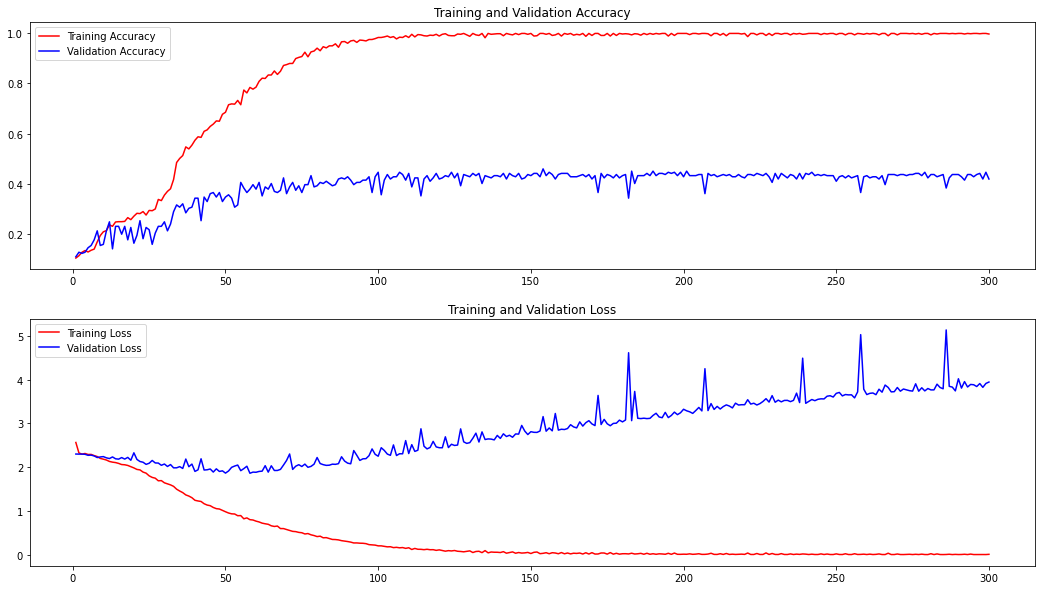

In [97]:
# Accuracy metric.
acc = small_model_history.history['acc']

# Validation accuracy metric.
val_acc = small_model_history.history['val_acc']

# Loss metric.
loss = small_model_history.history['loss']

# Validation loss metric.
val_loss = small_model_history.history['val_loss']

# Define limits for plot axis.
epochs = range(1, len(acc) + 1)

# Instantiate two subplots.
f, axs = plt.subplots(2,2,figsize=(18,10))

# Plot one for training and validation accuracy.
plt.subplot(2,1,1)
plt.title('Training and Validation Accuracy')
plt.plot(epochs, acc, 'red', label='Training Accuracy')
plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy')
plt.legend()


# Plot two for training and validation loss.
plt.subplot(2,1,2)
plt.title('Training and Validation Loss')
plt.plot(epochs, loss, 'red', label='Training Loss')
plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
plt.legend()

plt.show()

In [103]:
print(f'Highest Accuracy Achieved: {round(max(val_acc),3)*100}% at epoch number {np.argmax(val_acc)}')

Highest Accuracy Achieved: 46.0% at epoch number 153


At 46% accuracy we can ascertain that the simple CNN model can successfully classified the dataset, we have achieved statistical power.

Given this we can move onwards to more complex model training and improve upon this score.

### Data Augmentation

Data augmentation is the approach of generating more training samples from the existing batch. This process cannot create entirely new images but it can modify and distort existing images via a number of random transformations that yield believable-looking images. This process hopes to improve the generalisation ability of the model, given that during training the model will never see the exact image twice. Data augmentation is especially useful in small datasets such as this one, by increasing the training samples [5]. It is also important to note that only the training set is modified in this way, the validation and test generators remain the same.

In order to achieve this a separate data generator will be used with a number of augmentations applied.

In [16]:
augmented_train_generator = image.ImageDataGenerator(
                                rescale = 1./255, 
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest').flow_from_directory(
                                train_set,
                                target_size = (height, width),
                                batch_size = batch_size,
                                class_mode = 'categorical',
                                color_mode = 'rgb',
                                interpolation = 'nearest',
                                classes = None)

Found 874 images belonging to 10 classes.


### Callbacks

A number of call-backs have been created below to assist in model training and parameter evaluation.

The 'checkpoint' call-back saves the model to the desired path, in this instance it will save the model with the highest validation accuracy only and override as necessary.

The 'early_stop' call-back halts the training process if the model cannot improve upon a specified metric, i.e., validation accuracy, within a number of epochs. The metric monitored is validation accuracy as this has the most bearing upon the actual test set performance. The patience is set to 16 epochs to allow the model to break through plateaus using the reduce_lr call-back.

The 'reduce_lr' call-back is used in breaking through plateaus by reducing the learning rate if the defining metric does not improve within the specified time. This metric will be validation loss.

In [17]:
# File path for saving model.
filepath = str(os.getcwd()+'/model.h5f')

# Saves best performing model.
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

# Stops training if validation accuracy does not improve within 16 epochs.
early_stop = EarlyStopping(monitor='val_acc', patience=16, mode='max', restore_best_weights=True)

# Reduces the learning by a factor of 0.5 if validation loss does not improve within 6 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=0.000001, verbose=0, mode='min')

### Model Building Function

In order to train and validate multiple models succinctly and efficiently the below model builder will be employed. All model metrics will be saved and analysed to uncover the optimal model architecture.


Not to reader: due to the large amount of time required to train models it is prohibitive to examine the full spectrum of hyperparameters in this report. As such only a few parameters will be analysed for the purposes of this exercise.


The model builder is static with regards to certain specifications which are outlined as follows:
1.	When batch normalisation is enabled, the layer will be added in between all other layers with the exception of the flatten layer. This is due to several online observations which depicted the model in this way. The batch normalisation layers also require the data format to be specified to 'channels last', as otherwise the model fails to properly initialise and validation accuracy does not improve.
2.	The filters start at 32 units and double for each successive layer. While no definitive rule exists, I have noticed several models depicting this as the norm.

In [18]:
def build_model(nb_layers=2, filters=32, kernel=(3,3), pad='valid', dense_units=32, 
                batch_norm=False, sepConv2D=False, dropout=None):
    """
    This function creates a neural network model with the RMSprop optimiser, 
    categorical crossentropy loss and accuracy as its metric. The activation functions are RELU, except for the last layer. 
    The last layer is comprised of 10 dense units and a softmax activation function.
    
    Inputs 
    nb_layers: The number of layers in the model.
    filters: The number of filters in the layer.
    kernel: A tuple consisting of the size of the layer.
    pad: The padding used in the layer.
    dense_units: The number of units to use in the dense layer.
    batch_norm: If set to True, will use batch normalisation layers.
    sepConv2D: If set to True, will create all layers using depth wise convolutions.
    dropout: Add dropout value to the amount input, only added to the final layer.
    
    Output
    Returns a compiled model with the specified hyperparameters.
    """
    
    # Instantiate the neural network model.    
    model = models.Sequential()
    
    # Boolean value to control and differentiate between the first and subsequent layers.    
    first_layer = True
    
    # Looping through the number of layers.
    for layer in range(nb_layers):
        
        # If depthwise convolution parameter set to True.
        if sepConv2D:
            
            # Signify the first layer - which must be built differently to subsequent layers.
            if first_layer:
                
                # If batch normalisation parameter set to true.
                if batch_norm:
                    
                    # Add layer using filter, kernel and padding pre-defined in the hyperparameters.
                    model.add(layers.SeparableConv2D(filters, kernel, activation='relu', padding=pad, 
                                 input_shape=(height, width, channels), data_format='channels_last'))
                    
                    # Add batch normalisation layer.
                    model.add(layers.BatchNormalization())
                    
                    # Add max pooling layer.
                    model.add(layers.MaxPooling2D((2, 2)))
                    
                    # Add batch normalisation layer.
                    model.add(layers.BatchNormalization())
                    
                # If batch normalisation set to False.    
                else:  
                    
                    # Add separable convolution layer.
                    model.add(layers.SeparableConv2D(filters, kernel, activation='relu', padding=pad, 
                                    input_shape=(height, width, channels), data_format='channels_last'))
                    
                    # Add max pooling layer.
                    model.add(layers.MaxPooling2D((2, 2)))
 
                # Set boolean value to false so loop builds remaining layers using below layer layout.
                first_layer = False

                    
            # Subsequent layer creation.
            else:
                
                # Double filter count.
                filters*=2
                
                # If batch normalisation parameter set to true. 
                if batch_norm:
                    
                    # Add layer using filter, kernel and padding pre-defined in the hyperparameters.
                    model.add(layers.SeparableConv2D((filters), kernel, padding=pad, activation='relu', 
                                                     data_format='channels_last'))
                    
                    # Add batch normalisation layer. 
                    model.add(layers.BatchNormalization())
                    
                    # Add max pooling layer.
                    model.add(layers.MaxPooling2D((2, 2)))
                    
                    # Add batch normalisation layer.
                    model.add(layers.BatchNormalization())
                
                # If batch normalisation set to False.  
                else:
                    
                    # Add layer using filter, kernel and padding pre-defined in the hyperparameters.
                    model.add(layers.SeparableConv2D((filters), kernel, padding=pad, activation='relu',
                                                     data_format='channels_last'))
                    
                    # Add max pooling layer.
                    model.add(layers.MaxPooling2D(2, 2))

                
        # If sepConv2D set to false.
        else:
            
            # Signify the first layer - which must be built differently to subsequent layers.
            if first_layer:
                
                # If batch normalisation parameter set to true. 
                if batch_norm:
                    
                    # Add layer using filter, kernel and padding pre-defined in the hyperparameters.
                    model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding=pad,
                                            input_shape=(height, width, channels)))
                    
                    # Add batch normalisation layer. 
                    model.add(layers.BatchNormalization())
                    
                    # Add max pooling layer.
                    model.add(layers.MaxPooling2D((2, 2)))
                    
                    # Add batch normalisation layer. 
                    model.add(layers.BatchNormalization())
                
                # If batch normalisation parameter set to false.
                else:
                    
                    # Add layer using filter, kernel and padding pre-defined in the hyperparameters.
                    model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding=pad, 
                                            input_shape=(height, width, channels)))
                    
                    # Add max pooling layer.
                    model.add(layers.MaxPooling2D((2, 2)))
                
                    
                # Set boolean value to false so loop builds remaining layers using below layer layout.
                first_layer = False
            
            # Subsequent layer creation. 
            else:    
                
                # Double filter count.
                filters*=2
                
                # If batch normalisation parameter set to true. 
                if batch_norm:
                    
                    # Add layer using filter, kernel and padding pre-defined in the hyperparameters.
                    model.add(layers.Conv2D((filters), kernel, padding=pad, activation='relu'))
                    
                    # Add batch normalisation layer. 
                    model.add(layers.BatchNormalization())
                    
                    # Add max pooling layer.
                    model.add(layers.MaxPooling2D((2, 2)))  
                    
                    # Add batch normalisation layer. 
                    model.add(layers.BatchNormalization())
                        
                # If batch normalisation parameter set to false.     
                else:               
                    
                    # Add layer using filter, kernel and padding pre-defined in the hyperparameters.
                    model.add(layers.Conv2D((filters), kernel, padding=pad, activation='relu'))
                    
                    # Add max pooling layer.
                    model.add(layers.MaxPooling2D((2, 2)))

        
    # Flatten the output of the previous layer.    
    model.add(layers.Flatten())

    # Add dense layer, specified in the hyperparameters.
    model.add(layers.Dense(dense_units, activation='relu'))
    
    # Add batch normalisation layer if set to true.
    if batch_norm:
        model.add(layers.BatchNormalization())
    
    # If dropout add layer to the amount specified.
    if dropout:
        model.add(layers.Dropout(dropout))
    
    # Add final dense layer consisting of 10 units for the 10 classes and a softmax activation function.
    model.add(layers.Dense(10, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
    
    # Return compiled model.
    return model

### Testing a Series of Models

In this section I will test a large number of models with differing hyperparameters to uncover the optimal model architecture for this specific problem. The model training process is very long, therefore not all hyperparameters will be tested in this report.

In [55]:
# Creating a list of models with differing hyperparamters to train and validate.

models = [build_model(nb_layers=3, filters=32, kernel=(3,3), pad='valid', dense_units=32, 
                      batch_norm=True, sepConv2D=False, dropout=0.2), # Model1
          
          build_model(nb_layers=4, filters=32, kernel=(3,3), pad='valid', dense_units=32, 
                      batch_norm=True, sepConv2D=False, dropout=0.2), # Model2
          
          build_model(nb_layers=5, filters=32, kernel=(3,3), pad='valid', dense_units=32, 
                      batch_norm=True, sepConv2D=False, dropout=0.2), # Model3
          
          build_model(nb_layers=3, filters=32, kernel=(3,3), pad='valid', dense_units=32, 
                      batch_norm=True, sepConv2D=True, dropout=0.2), # Model4
          
          build_model(nb_layers=4, filters=32, kernel=(3,3), pad='valid', dense_units=32, 
                      batch_norm=True, sepConv2D=True, dropout=0.2), # Model5
          
          build_model(nb_layers=5, filters=32, kernel=(3,3), pad='valid', dense_units=32, 
                      batch_norm=True, sepConv2D=True, dropout=0.2), # Model6
          
          build_model(nb_layers=3, filters=32, kernel=(3,3), pad='valid', dense_units=64, 
                      batch_norm=True, sepConv2D=True, dropout=0.2), # Model7
          
          build_model(nb_layers=4, filters=32, kernel=(3,3), pad='valid', dense_units=64, 
                      batch_norm=True, sepConv2D=True, dropout=0.2), # Model8
          
          build_model(nb_layers=5, filters=32, kernel=(3,3), pad='valid', dense_units=64, 
                      batch_norm=True, sepConv2D=True, dropout=0.2), # Model9
          
          build_model(nb_layers=3, filters=32, kernel=(3,3), pad='valid', dense_units=64, 
                      batch_norm=True, sepConv2D=False, dropout=0.2), # Model10
          
          build_model(nb_layers=4, filters=32, kernel=(3,3), pad='valid', dense_units=64, 
                      batch_norm=True, sepConv2D=False, dropout=0.2), # Model11
          
          build_model(nb_layers=5, filters=32, kernel=(3,3), pad='valid', dense_units=64, 
                      batch_norm=True, sepConv2D=False, dropout=0.2), # Model12
          
          build_model(nb_layers=3, filters=32, kernel=(3,3), pad='valid', dense_units=128, 
                      batch_norm=True, sepConv2D=True, dropout=0.2), # Model13
          
          build_model(nb_layers=4, filters=32, kernel=(3,3), pad='valid', dense_units=128, 
                      batch_norm=True, sepConv2D=True, dropout=0.2), # Model14
          
          build_model(nb_layers=5, filters=32, kernel=(3,3), pad='valid', dense_units=128, 
                      batch_norm=True, sepConv2D=True, dropout=0.2), # Model15
          
          build_model(nb_layers=3, filters=32, kernel=(3,3), pad='valid', dense_units=128, 
                      batch_norm=True, sepConv2D=False, dropout=0.2), # Model16
          
          build_model(nb_layers=4, filters=32, kernel=(3,3), pad='valid', dense_units=128, 
                      batch_norm=True, sepConv2D=False, dropout=0.2), # Model17
          
          build_model(nb_layers=5, filters=32, kernel=(3,3), pad='valid', dense_units=128, 
                      batch_norm=True, sepConv2D=False, dropout=0.2)] # Model18



# Instantiating a list to record model summary.
model_summary = []

# Instantiating a dictionary to record model history.
histories = {}

# Looping through the model list.
for index, model in enumerate(models):
    
    # Save the model summary to the list.
    model_summary.append(model)
    
    # Track the iterations of the model list using print statements.
    print(f'Training model {index}/{len(models)}')
    
    # Train, validate and save model history to a dictionary.
    histories[f'model_{index}'] = model.fit(augmented_train_generator,
                                            epochs=100,
                                            validation_data=validation_generator,
                                            callbacks=[early_stop, reduce_lr, checkpoint],
                                            verbose=0)
    
    # Print statement once all models have completed validation.
    if (index) == len(models):
        print('Training Complete')

### Model Selection

All models will now be examined in order to select the highest performing architecture. The models will be compared against each other by the validation accuracy metric.

In order to achieve this the validation accuracy for each model will be transferred into a dataframe. The dataframe allows for easier interpretation and visualisation of the validation metric.

In [21]:
# Convert the dictionary to a Dataframe using list comprehension.
history_df = pd.DataFrame(dict([(i,pd.Series(v.history['val_acc'])) for i,v in histories.items()]))

In [22]:
# Using list comprehension to get the maximum accuracy per model.
max_val_acc = [(model,round(max(history_df[model])*100,2)) for model in history_df]

# Sorting the list by validation accuracy.
max_val_acc.sort(key=lambda x: x[1], reverse=True)

In [23]:
# Loop through the sorted list and print the model and its respective validation accuracy.

for index, model in enumerate(max_val_acc):
    print(f'Rank {index+1}: {model[0]} = {model[1]}%')

Rank 1: model_17 = 83.48%
Rank 2: model_2 = 81.7%
Rank 3: model_16 = 80.36%
Rank 4: model_11 = 79.91%
Rank 5: model_10 = 79.46%
Rank 6: model_1 = 77.68%
Rank 7: model_8 = 76.79%
Rank 8: model_15 = 74.11%
Rank 9: model_9 = 73.21%
Rank 10: model_12 = 72.77%
Rank 11: model_5 = 72.32%
Rank 12: model_0 = 71.88%
Rank 13: model_13 = 70.54%
Rank 14: model_4 = 70.09%
Rank 15: model_6 = 66.96%
Rank 16: model_3 = 61.61%
Rank 17: model_7 = 10.27%
Rank 18: model_14 = 9.82%


We can observe from this ranking that model 17 performed the best on the validation set.

It is curious that model 7 and 14 achieved such an abysmal accuracy score, they failed to initialise. I have noticed that during the training process the validation loss increases substantially for the first few epochs before decreasing in line with regular loss. This causes the validation accuracy to remain stagnant for a number of epochs. It would appear that the early_stop call-back halted the training before the model could begin decreasing its validation loss. Nonetheless both models had 16 epochs to improve their validation accuracy, which they failed to achieve.

In the cell below I will examine the architecture of the top models and note any interesting patterns or observations. Only the top 3 models will be examined due to the amount of space the model summary occupies.

In [48]:
# Loop through the top 3 models.
for model in max_val_acc[:3]:
    
    # Remove non-numerical characters and subtract by 1 to align to the model training & saving process.
    model_id = int(re.sub('[^0-9]', '', model[0]))
    
    # Print the model summary and identifier.
    print(f'Model Number: {model_id}', model_summary[model_id].summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_151 (Bat (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_152 (Bat (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_153 (Bat (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 36, 36, 64)      

An interesting observation is that none of these top performing models have used the depthwise convolution layer. Depthwise is regarded as being superior both in training speed and performance, yet the results in this experiment are to the contrary. Depth wise layers are lighter and use fewer floating-point operations, for this reason they possess fewer trainable parameters and as such can perform worse on certain tasks, as it appears to be the case in this experiment.

### Visualising Model Validation

Visualisations assist in model selection by allowing the user to understand the training process as well as contrast and compare multiple models.

This will be performed for the top three models previously trained, before choosing the final model architecture.

In [44]:
# Create mask to filter the dataframe using top three models.
mask = [model[0] for model in max_val_acc[:5]]

In [45]:
# Filter dataframe for the top three models.
models_df = history_df.filter(mask, axis=1)

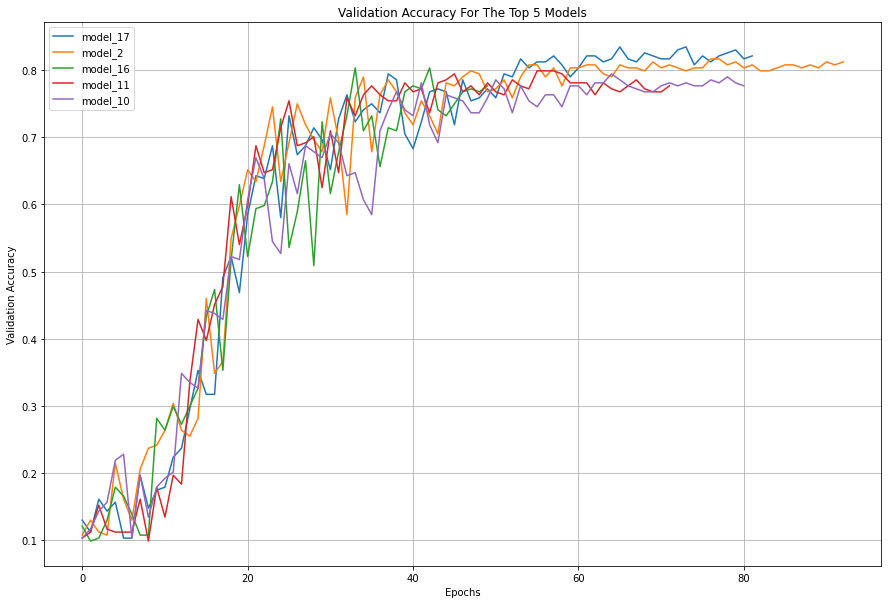

In [47]:
# Visualise the new filtered dataframe comprised of the five models.
models_df.plot(figsize=(15,10), title='Validation Accuracy For The Top 5 Models', grid=True, 
               xlabel ='Epochs', ylabel='Validation Accuracy')
plt.show()

The training process is quite volatile with large jumps in validation accuracy with every epoch, especially during the early phase of model training. It is clear from this graph that model 17 edges out the other models by being consistently at the top. The other models also appear to have hit the glass ceiling in terms of what they can achieve given their architecture. The only model which may have seen further improvements in validation accuracy is model 16, given that its training terminated around epoch 45. However as the model is sequentially behind model 17 which is the top performer we can assume that model 16's architecture would have limited its ability to overtake its larger counterpart.

Model 17 is therefore chosen to proceed to the next step.

### Optimal Epoch

Using the call-backs previously defined, precisely the early stop call-back, it is no longer necessary to re-run the entire neural network process in order to identify the optimal epoch for the dataset. This call-back precisely monitors the maximum validation accuracy achieved and after 16 epochs stops the training process if no improvements to the validation accuracy are detected. Additionally and most crucially the early stop call back then reverts its model weights to those achieved in the highest accuracy epoch. Consequently this epoch is the optimal epoch for the model.

The optimal epoch for model 17 is 65, this will be used to re-train the dataset using the entirety of the training set.

## Re-Train Optimal Model Using Full Train Set

The next step is to re-train the optimal model for the optimal number of epochs. In order to achieve this the original training set will be used alongside a new augmented training generator. It is this fully re-trained model which will then be tested on the test data.

In [19]:
# Creating a new path to a full training set.
full_train_set = Path('C:\\Users\\Stas\\Desktop\\monkey_images\\training\\training')

In [20]:
# Creating a new augmented data generator which uses the full train set.
augmented_full_train_generator = image.ImageDataGenerator(
                                    rescale = 1./255, 
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest').flow_from_directory(
                                    full_train_set,
                                    target_size = (height, width),
                                    batch_size = batch_size,
                                    class_mode = 'categorical',
                                    color_mode = 'rgb',
                                    interpolation = 'nearest',
                                    classes = None)

Found 1098 images belonging to 10 classes.


In [38]:
# Using the model builder to re-build model 17.
model_17 = build_model(nb_layers=5, filters=32, kernel=(3,3), pad='valid', dense_units=128, 
                       batch_norm=True, sepConv2D=False, dropout=0.2)

# Training the new model upon the full training set.
model_17_history = model_17.fit(augmented_full_train_generator,
                                epochs=65,
                                verbose=0)

## Model Evaluation

Model 17 will be used for test set evaluation and prediction.

To do this the model will be loaded back into this report which was previously saved using the callback.

In [33]:
# Evaluate the model upon the test set.
test_loss, test_acc = model_17.evaluate(test_generator, verbose=0)

In [34]:
print(f'Accuracy achieved on test set: {round(test_acc,4)*100}%')
print(f'Loss on test set: {round(test_loss,4)}')

Accuracy achieved on test set: 86.03%
Loss on test set: 0.5531


The accuracy score is surprising how strong it is when compared to the validation accuracy achieved previously. The validation accuracy is 83% which equates to a roughly 3% gain in accuracy on the test set.
This increase in accuracy is a result of training the model on the entire dataset.

### Confusion Matrix

To complete the results examination we will examine the confusion matrix to identify which classes the model has trouble classifying.

In [35]:
# Assigning labels to variable.
labels = labels_df['CommonName']

In [36]:
def plot_confusion_matrix(cm, target_names):
    """
    Plot a detailed color coded confusion matrix displaying the accuracy and missmatch of the model.
    
    Inputs
    cm: sk.learn confusion matrix
    target_names: the class labels.
    
    Returns: confusion matrix
    """
    
    # Calculate the accuracy.
    accuracy = np.trace(cm) / float(np.sum(cm))
    
    # Calculate the error.
    misclass = 1 - accuracy
    
    # Create the confusion matrix
    cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    
    # Convert to float and transform data representation to percentage.
    cm = cm.astype('float32') / cm.sum(axis=1)
    cm = np.round(cm,2)
    
    # Add class names to x-axis & y-axis ticks.
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    
    # Create confusion matrix based upon number of classes.
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    # Plot confusion matrix.
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

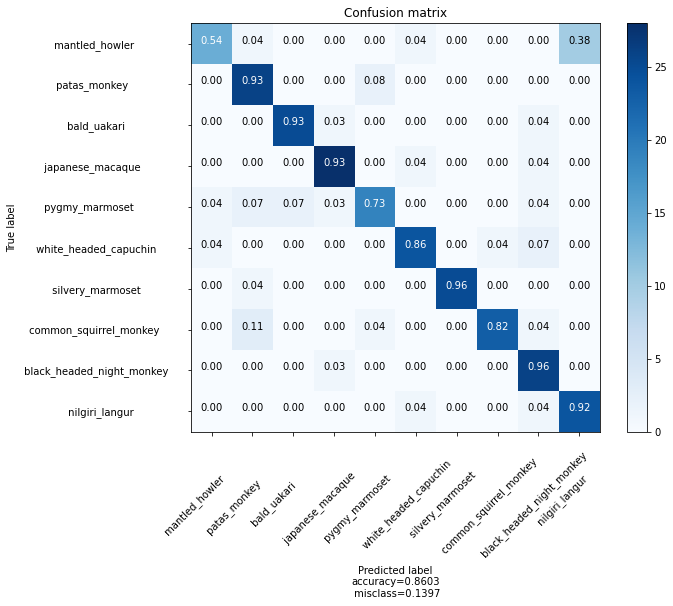

In [37]:
# Predicting the model on the test set.
predictions = model_17.predict(test_generator)

# Convert predictions classes to one hot vectors.
predicted_classes = np.argmax(predictions, axis=1)

# Create confusion matrix using actual and predicted classes.
cm = confusion_matrix(y_true=test_generator.classes, y_pred=predicted_classes)

# Plotting the confusion matrix.
plot_confusion_matrix(cm, target_names=labels)

### Results

The accuarcy score of 86% is good considering it was trained using just a handful of images per class. The validation accuracy was 83% which is 3% lower than the actual test set. The effectiveness of re-training the model on the whole training set is apparent. 

Interestingly the mantled howler is highly misclassified, at only 54% accuracy. Its recall is low and is highly confused with the nilgiri_langur at a rate of 34%. The only other point of confusion for the model is the pygmy_marmoset. All other classes achieve a very good accuracy of around +90%.

The first of three possible ways of improving this result is through more aggressive image augmentation. The augmentation settings can be increased to further rotate, shear and zoom images thereby increasing the variety of images observed by the model and potentially improving performance on the test set. The second technique is to increase the dropout rate from 0.2 to 0.5. This will prevent a portion of the neurons from optimizing their weights synchronously which leads to overfitting the training set. Furthermore, given the observed effectiveness of the re-training the dataset I believe that implementing cross-validation would significantly improve the model performance especially as the entirety of the dataset is used in model training. Furthermore the train test split bias is minimised as all portions of the dataset take turns participating in the training and validation.

While the model may perform a few points higher using the techniques described above it may still be limited in its capability simply due to its very small training set. To counteract this limitation we can use pretrained covnet and apply it to our dataset.

# Pre-trained Convnet Model

When the dataset is small, it is difficult to create an accurate and well generalising model as there is not enough data to learn the shapes and patterns that may be found in future test sets. One way to circumvent this issue is by using a pretrained model. This type of model offers a variety of benefits such as much better accuracy due to a custom-built convolution architecture and the fact that such models are trained on large datasets. Therefore, the pretrained model can generalise well as the shapes, patterns and edges the model was trained on can be applied to other problem areas as well. An additional benefit is that such a model is easier to train and requires less effort in set up and training compared to creating a model from scratch.

The Xception model with the 'imagenet' pre-set will be used in this report to classify the dataset. It is specifically   chosen because it has been trained on animal photos and therefore it should transition well to the current task. The Xception model is also quite heavy in terms of trainable parameters which should translate to higher accuracy as opposed to a simpler pretrained covnet such as VGG16. Furthermore the Xception model will be fine-tuned to achieve the maximum possible accuracy on this dataset.

The first step in pretrained model creation is to load the model without the top layer, the dense layer, which will be replaced with a custom layer specific to the task at hand. It is also crucial to freeze all layers to prevent the model from retraining completely and erasing its already trained

In [24]:
# Instantiating Xception model without top dense layer.
xception_model = Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(height, width, channels))

# Prevent model from being trainable.
xception_model.trainable = False

# Create a light data augmentation layer.
data_augmentation = keras.Sequential([layers.RandomFlip('horizontal'), layers.RandomRotation(0.1)])

# Create new model to go on top of Xception base.
inputs = keras.Input(shape=(height, width, channels))

# Apply image augmentation to input.
x = data_augmentation(inputs)

# Xception model requires images to be scaled to range (-1., +1.)
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)

# Apply scaling layer to input.
x = scale_layer(x)

# Ensure base layers are running in inference mode for when fine-tuning is performed.
x = xception_model(inputs, training=False)

# Apply global averaging layer.
x = keras.layers.GlobalAveragePooling2D()(x)

# Add dense layer.
x = layers.Dense(256, activation='relu')(x)

# Apply dropout.
x = keras.layers.Dropout(0.2)(x)

# Add final layer comprised of 10 neurons for the 10 classes and softmax activation function.
outputs = keras.layers.Dense(10, activation='softmax')(x)

# Model created.
x_model = keras.Model(inputs, outputs)

### Callbacks

There are two key call-backs used during the training of the Xception model. The first call-back is to ensure the model is saved to the local machine, while not overriding the best model that was developed from scratch. The second key call-back is early_stop which simplifies model training by restoring the weights of the model to its optimal validation accuracy configuration which means that the model does not need to be retrained from scratch before evaluating the test set. This allows us for succinct advancement into model fine-tuning.

In [25]:
# Callback to save best xception model.
xception_checkpoint = ModelCheckpoint(filepath=str(os.getcwd()+'/xception_model.h5f'), monitor='val_acc', 
                                      verbose=0, save_best_only=True, mode='max')

In [22]:
# Compile model.
x_model.compile(loss='categorical_crossentropy', 
                optimizer=optimizers.RMSprop(learning_rate=1e-4), 
                metrics=['acc'])

# Train and validate xception model.
xception_history = x_model.fit(train_generator,
                               epochs=100,
                               validation_data=validation_generator,
                               callbacks=[early_stop, reduce_lr, xception_checkpoint],
                               verbose=0)

Visualise the Xception model training process.

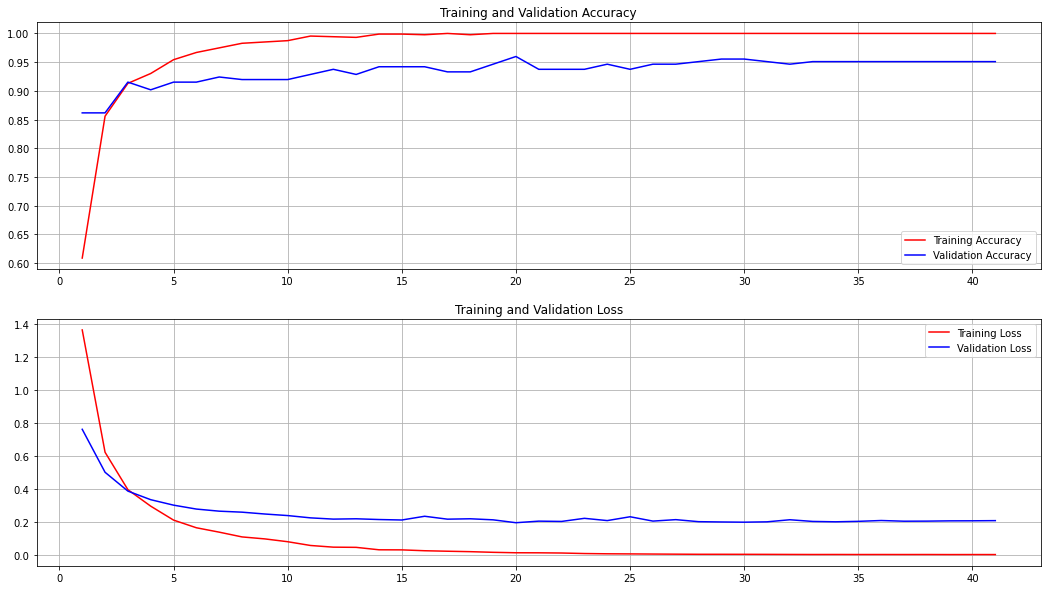

In [20]:
# Set boundaries based upon the number of epochs +1
epochs = range(1, len(xception_history.history['val_acc']) + 1)

# Creating figure and axis two plots.
f, axs = plt.subplots(2,2,figsize=(18,10))

# Subplot for the accuracy metric.
plt.subplot(2,1,1)
plt.title('Training and Validation Accuracy')
plt.plot(epochs, xception_history.history['acc'], 'red', label='Training Accuracy')
plt.plot(epochs, xception_history.history['val_acc'], 'blue', label='Validation Accuracy')
plt.legend()
plt.grid()

# Subplot for the loss metric.
plt.subplot(2,1,2)
plt.title('Training and Validation Loss')
plt.plot(epochs, xception_history.history['loss'], 'red', label='Training Loss')
plt.plot(epochs, xception_history.history['val_loss'], 'blue', label='Validation Loss')
plt.legend()
plt.grid()

plt.show()

In [30]:
print(f'Best Accuracy achieved using Xception - {round(max(xception_history.history["val_acc"]),3)*100}% '
      f'at epoch number {np.argmax(xception_history.history["val_acc"])}.')

Best Accuracy achieved using Xception - 96.0% at epoch number 19.


## Fine-tuning

It is possible to further improve model performance by tuning some of the layers in the pretrained model. This is accomplished by unfreezing a few of the top layers and training the model with the previously created top layer. Only the top layers in the model are retrained as they provide more relevant data to the problem at hand. The bottom layers deal with more abstract patterns which can be applied to a variety of tasks moving beyond what the model was originally trained upon. As such a model trained on animal images could be used for furniture classification.

It is crucial however that the custom dense layer is trained before unfreezing the top layers in the convolution base. Failing to do so results in too large of an error signal propagating through the model, destroying the previously trained weights.

The first part has already been accomplished, the dense layer has been trained. The next step is to unfreeze a few of the top layers and train the model once more.

In [26]:
# Examine Xception model layers.
xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Using the summary function, we can identify the bottom two layers, comprised of depth wise convolutions which will be unfrozen and trained using the dataset. It is important to note here that while the model becomes trainable it is still running in inference mode due to 'training=False' variable [6]. This means that the batch normalisation layers will not override their batch statistics when fine-tuned.

As a key note notice that the current trainable parameters in the model summary are 0, which is correct given that the base was frozen and the top layer was replaced with a problem specific dense layer.

In [24]:
# Allow model to be trainable.
xception_model.trainable = True

# Set boolean parameter.
set_trainable = False

# Loop through all layers in model.
for layer in xception_model.layers:
    
    # Allow two bottom layers to be trainable.
    if layer.name == 'block14_sepconv1' or layer.name == 'block14_sepconv2':
        set_trainable = True    
    if set_trainable:
        layer.trainable = True
        
    # All other layers to remain untrainable.    
    else:
        layer.trainable = False

Let’s examine the total number of trainable parameters now available in the Xception base model. The previous count was 0.

In [26]:
print(f'Number of trainable parameters - {count_params(xception_model.trainable_weights)}')

Number of trainable parameters - 4748800


There are now almost 5 million parameters ready to be trained on the dataset.

Before proceeding, a new checkpoint call-back will be created to distinguish this model from the previous Xception model.

In [27]:
# Checkpoint callback for tuned Xception model.
xception_tuned_checkpoint = ModelCheckpoint(filepath=str(os.getcwd()+'/xception_tuned.h5f'), monitor='val_acc', 
                                            verbose=0, save_best_only=True, mode='max')

When fine-tuning a covnet model it is crucial to use  a low learning rate as to not propagate a large error signal and destroy the previously learned top layer weights.

In [206]:
# Compiling the model with a low learning rate.
x_model.compile(loss='categorical_crossentropy', 
                optimizer=optimizers.RMSprop(learning_rate=1e-5), 
                metrics=['acc'])

# Train and evaulate model.
xception_tuned_history = x_model.fit(train_generator,
                                     epochs=100,
                                     validation_data=validation_generator,
                                     callbacks=[early_stop, reduce_lr, xception_tuned_checkpoint],
                                     verbose=0)

## Results

The results of the fine-tuned model will be examined and contrasted to those of the model created from scratch.

In [196]:
# Loading previously trained model.
xception_model = load_model('xception_tuned.h5f')

In [27]:
# Evaluating the tuned model.
xception_loss, xception_acc = xception_model.evaluate(test_generator, verbose=0)

In [229]:
print(f'Accuracy achieved on test set: {round(xception_acc,4)*100}%')
print(f'Loss on test set: {round(xception_loss,4)}')

Accuracy achieved on test set: 92.28%
Loss on test set: 0.3142


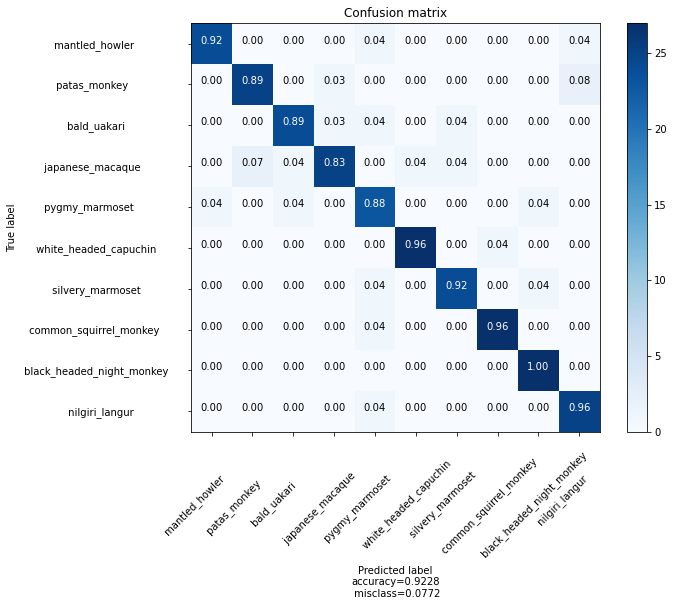

In [236]:
# Predicting the model on the test set.
predictions = xception_model.predict(test_generator)

# Convert predictions classes to one hot vectors.
predicted_classes = np.argmax(predictions, axis=1)

# Create confusion matrix using actual and predicted classes.
cm = confusion_matrix(y_true=test_generator.classes, y_pred=predicted_classes)

# Plotting the confusion matrix.
plot_confusion_matrix(cm, target_names=labels)

The test set accuracy is 92%, a staggering 6% improvement on the custom model created using hyperparameter optimisation.  The confusion matrix is also noticeably improved with a much lower misclassification rate. The mantled_howler monkey has also been correctly classified as opposed to the 54% accuracy previously achieved. Interestingly the common squirrel monkey has achieved the golden standard in accuracy at 100%. All classes have benefited a notable improvement in accuracy.

A key advantage of using a pretrained model is the vast amount of time and effort saved in model creation while also achieving a significantly better result as opposed to manual model creation. For small datasets it appears that foregoing the training of a custom model and delving straight in to a pretrained covnet is a viable strategy. The common-sense baseline as well as beating this baseline using a small model are still crucial steps in the machine learning workflow, however the time consumption of a custom model trained from scratch may not be worth the time investment. Again this only applies to small datasets such as this one with just over a 1000 images split between training, validating and testing.


#### Hyperparameter optimisation
The hyperparameter optimisations process was unfortunately cut short due to the large waiting times for model training, even with the use of the early_stop call-back. For example, the total training time for the 18 tested models took roughly 10 hours on a n average PC. Therefore the model optimisation process needs to be streamlined.
An improvement to hyperparameter optimisation can be to gradually test all hyperparameters successively. This entails to start of with the basics. First train models using the key architecture parameters such as the number of layers, number of filter units and dense layer weights. This process will focus on just one hyperparameter at a time. The model testing function should automatically choose the best hyperparameters as they are uncovered. Once the architecture is in place the other hyperparameters can be tested, such as the padding, kernel size and other presumably less impactful hyperparameters.
This was the optimisation function will successively test all kernel sizes, pick the best one and move on to the next hyperparameter, iteratively building the model with the most optimal architecture.


#### Possible issue/improvement

The validation set is very small in this particular problem. It would have been wiser to use K-fold validation to iteratively use the entirety of the training set for training and validation. As it stands, because the validation set was very small the model evaluation may not be correctly displayed. Furthermore in such small datasets it is crucial to use the entirety of the dataset for training where further gains in accuracy can be obtained.

# References

[1] Kaggle.com. 2022. 10 Monkey Species. [online] Available at: <https://www.kaggle.com/slothkong/10-monkey-species> [Accessed 16 February 2022].

[2] Analytics Vidhya. 2022. Image Classification Using CNN -Understanding Computer Vision. [online] Available at: <https://www.analyticsvidhya.com/blog/2021/08/image-classification-using-cnn-understanding-computer-vision/> [Accessed 26 February 2022].

[3] Paperswithcode.com. 2022. Papers with Code - Depthwise Convolution Explained. [online] Available at: <https://paperswithcode.com/method/depthwise-convolution#:~:text=Depthwise%20Convolution%20is%20a%20type%20of%20convolution%20where,channels%20to%20generate%20each%20element%20in%20the%20output.> [Accessed 26 February 2022].

[4] scikit-learn. 2022. sklearn.dummy.DummyClassifier. [online] Available at: <https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html> [Accessed 20 February 2022].

[5] https://research.aimultiple.com/data-augmentation/. 2022. What is Data Augmentation? Techniques & Examples in 2022. [online] Available at: <https://research.aimultiple.com/data-augmentation/> [Accessed 26 February 2022].

[6] Team, K., 2022. Keras documentation: Transfer learning & fine-tuning. [online] Keras.io. Available at: <https://keras.io/guides/transfer_learning/> [Accessed 24 February 2022].